In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('nd.csv',sep = ';') #,converters={"Close":float}

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,13.12.2011,24959999,25129999,24139999,24309999,21125864,1855800
1,14.12.2011,24180000,24360001,23920000,24059999,20908606,1597400
2,15.12.2011,24490000,24530001,24139999,24250000,21073723,1260500
3,16.12.2011,24430000,24520000,23980000,24030001,20882536,1900400
4,19.12.2011,24100000,24260000,23559999,23610001,20517548,1286800


In [4]:
train = df.loc[:, ["Close"]].values

In [5]:
train = train.astype(float)

In [6]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train)
train_scaled

array([[0.03697012],
       [0.03395953],
       [0.03624759],
       ...,
       [0.95640661],
       [0.97892582],
       [0.9779624 ]])

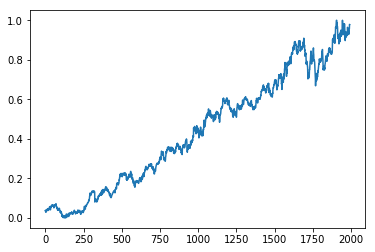

In [7]:
plt.plot(train_scaled)
plt.show()

In [8]:
train.size

1992

In [9]:
# Creating a data structure with 50 timesteps and 1 output
X_train = []
y_train = []
timesteps = 45
for i in range(timesteps, 1992):
    X_train.append(train_scaled[i-timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

array([[[0.03697012],
        [0.03395953],
        [0.03624759],
        ...,
        [0.06165705],
        [0.05985066],
        [0.06635357]],

       [[0.03395953],
        [0.03624759],
        [0.03359828],
        ...,
        [0.05985066],
        [0.06635357],
        [0.0670761 ]],

       [[0.03624759],
        [0.03359828],
        [0.02854047],
        ...,
        [0.06635357],
        [0.0670761 ],
        [0.06454721]],

       ...,

       [[0.99975919],
        [0.98265892],
        [0.92618019],
        ...,
        [0.92943159],
        [0.94749517],
        [0.95484104]],

       [[0.98265892],
        [0.92618019],
        [0.92654144],
        ...,
        [0.94749517],
        [0.95484104],
        [0.95640661]],

       [[0.92618019],
        [0.92654144],
        [0.9364162 ],
        ...,
        [0.95484104],
        [0.95640661],
        [0.97892582]]])

In [11]:
print(y_train.size)
print(X_train.size)

1947
87615


# rnn model

In [12]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 45,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 45,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 45,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 45))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 30, batch_size = 32)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1947/1947 [==============================] - 15s 7ms/step - loss: 0.2394
Epoch 2/30
1947/1947 [==============================] - 11s 5ms/step - loss: 0.1332
Epoch 3/30
1947/1947 [==============================] - 11s 6ms/step - loss: 0.0746
Epoch 4/30
1947/1947 [==============================] - 10s 5ms/step - loss: 0.0538
Epoch 5/30
1947/1947 [==============================] - 10s 5ms/step - loss: 0.0391
Epoch 6/30
1947/1947 [==============================] - 11s 5ms/step - loss: 0.0328
Epoch 7/30
1947/1947 [==============================] - 11s 5ms/step - loss: 0.0253
Epoch 8/30
1947/1947 [==============================] - 11s 5ms/step - loss: 0.0205
Epoch 9/30
1947/1947 [==============================] - 11s 5ms/step - loss: 0.0181
Epoch 10/

In [16]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('nd_test.csv',sep = ';')
dataset_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,13.11.2019,102050003,103750000,101239998,103269997,102802803,805700
1,14.11.2019,103269997,103309998,102389999,103260002,102792854,804600
2,15.11.2019,103110001,104150002,102830002,103589996,103121353,2597200
3,18.11.2019,103779999,104680000,103519997,104599998,104126785,972200
4,19.11.2019,104800003,105239998,103779999,105070000,104594666,888200


In [17]:
real_stock_price = dataset_test.loc[:, ["Close"]].values


In [18]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((df['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values.reshape(-1,1)
inputs = scaler.transform(inputs)  # min max scaler
inputs.size

67

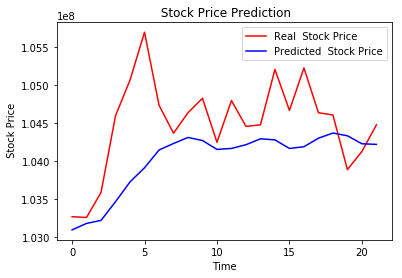

In [19]:
X_test = []
for i in range(timesteps, 67):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real  Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()
# epoch = 250 daha güzel sonuç veriyor.

In [69]:
print(predicted_stock_price.size)
print(real_stock_price.size)
print(dataset_total.size)
print(real_stock_price2.shape)




23
23
2037
(23, 1)
(23, 1, 1)


# lstm model

In [151]:
import numpy
import pandas as pd 
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [152]:
data = pd.read_csv('nd.csv',sep = ';')
data.head()
data['Date'] = pd.to_datetime(data['Date'])
#data.set_axis(data['Date'], inplace=True)
#data.drop(columns=['Open', 'High', 'Low', 'Volume','Adj Close'], inplace=True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-12-13,24959999,25129999,24139999,24309999,21125864,1855800
1,2011-12-14,24180000,24360001,23920000,24059999,20908606,1597400
2,2011-12-15,24490000,24530001,24139999,24250000,21073723,1260500
3,2011-12-16,24430000,24520000,23980000,24030001,20882536,1900400
4,2011-12-19,24100000,24260000,23559999,23610001,20517548,1286800


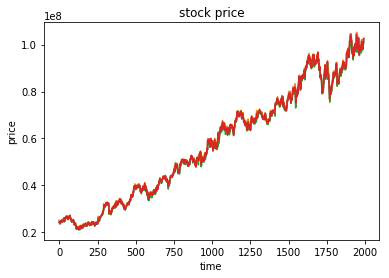

In [153]:
dataset = data.iloc[:,1:5].values
plt.plot(dataset)
plt.xlabel("time")
plt.ylabel("price")
plt.title("stock price")
plt.show()

In [154]:
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")
dataset.shape

(7968, 1)

In [155]:
# scaling 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [157]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 5577, test size: 2391 


In [158]:
train.shape

(5577, 1)

In [159]:
time_stemp = 15
dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = numpy.array(dataX)
trainY = numpy.array(dataY) 


In [160]:
print(trainX.shape)

(5561, 15)


In [161]:
dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = numpy.array(dataX)
testY = numpy.array(dataY)  

In [162]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [163]:
# model
model = Sequential()
model.add(LSTM(10, input_shape=(1, time_stemp))) # 10 lstm neuron(block)
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1)

Epoch 1/10
5561/5561 [==============================] - 46s 8ms/step - loss: 2.0601e-04
Epoch 2/10
5561/5561 [==============================] - 43s 8ms/step - loss: 9.0567e-05
Epoch 3/10
5561/5561 [==============================] - 46s 8ms/step - loss: 8.0172e-05
Epoch 4/10
5561/5561 [==============================] - 44s 8ms/step - loss: 6.9781e-05
Epoch 5/10
5561/5561 [==============================] - 45s 8ms/step - loss: 6.0961e-05
Epoch 6/10
5561/5561 [==============================] - 45s 8ms/step - loss: 5.6137e-05
Epoch 7/10
5561/5561 [==============================] - 45s 8ms/step - loss: 5.4141e-05
Epoch 8/10
5561/5561 [==============================] - 45s 8ms/step - loss: 5.1650e-05
Epoch 9/10
5561/5561 [==============================] - 45s 8ms/step - loss: 4.9070e-05
Epoch 10/10
5561/5561 [==============================] - 45s 8ms/step - loss: 4.5149e-05


In [12]:
print(trainX.shape)
print(trainY.shape)

(4759, 1, 20)
(4759,)


In [194]:
import pickle
# Save the Modle to file in the current working directory

Pkl_Filename = "model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [ ]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    model = pickle.load(file)

model

In [164]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 475358.10 RMSE
Test Score: 2967640.74 RMSE


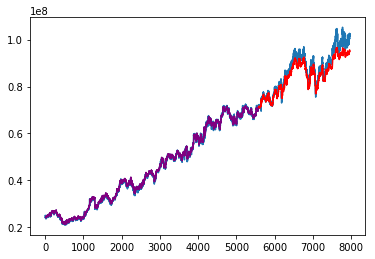

In [173]:
# shifting train
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict
# shifting test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot,color="purple")
plt.plot(testPredictPlot,color="red")
plt.show()

# forecasting

In [167]:
close_data = data['Close'].values
print(close_data.shape)
close_data = close_data.reshape((-1,1))
time_stemp = 15
close = []
for i in range(len(close_data)-time_stemp-1):
    a = close_data[i:(i+time_stemp), 0]
    close.append(a)
close_data = numpy.array(close)
print(close_data.shape)
close_data = close_data.reshape((-1,1))
#close_data = numpy.reshape(close_data, (close_data.shape[0], 1,close_data.shape[1] ))
#close_data = close_data.reshape((-1))
print(close_data.shape)


(1992,)
(1976, 15)
(29640, 1)


In [130]:
prediction_list = close_data[-look_back:]
print(prediction_list.shape)
x = prediction_list[-look_back:]
x2 = prediction_list[-look_back+5:]
print(x.shape)
print(x2.shape)
x = x.reshape((1,1, look_back))
#x.shape
out = model.predict(x)
print(out[0][0])

(20, 1)
(20, 1)
(15, 1)
1.2316636


In [191]:
look_back = 15
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]    
    for i in range(num_prediction):
        x = prediction_list[-look_back:]
        #x= numpy.reshape(x, (x.shape[0], x.shape[1],look_back ))
        x = x.reshape((1,1, look_back))
        out = model.predict(x)[0][0]
        #out=scaler.inverse_transform(out)
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]       
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = data['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates


In [193]:
forecast

array([ 1.00660004e+08,  1.04304564e+00,  1.04304564e+00,  1.04304564e+00,
        1.04304564e+00,  1.04304564e+00, -1.54021084e-01, -1.54021084e-01,
       -1.54021084e-01, -9.90042508e-01, -9.90042508e-01, -5.72031796e-01,
       -5.72031796e-01,  2.65015904e-02, -3.91509116e-01, -3.91509116e-01])

In [192]:
num_prediction = 15
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [170]:
forecast

array([ 1.00660004e+08,  1.04304564e+00,  1.04304564e+00,  1.04304564e+00,
        1.04304564e+00,  1.04304564e+00, -1.54021084e-01, -1.54021084e-01,
       -1.54021084e-01, -9.90042508e-01, -9.90042508e-01])

In [146]:
num_prediction = 30
forecast = predict(num_prediction, model)
forecast_date = predict_dates(num_prediction)

In [40]:
data.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
1987,2019-06-11,98160004,100080002,97980003,99919998,99467964,678200
1988,2019-07-11,100440002,100669998,99160004,100529999,100075203,959300
1989,2019-08-11,100309998,101260002,100160004,100660004,100204620,919700
1990,2019-11-11,100370003,102580002,100220001,102529999,102066154,825300
1991,2019-12-11,102629997,102629997,101300003,102449997,101986511,809400


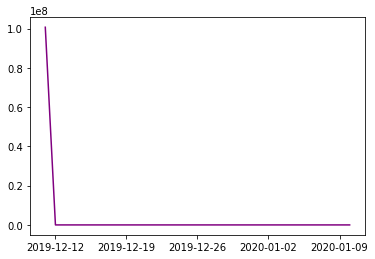

In [180]:
plt.plot(forecast_dates,forecast,color="purple")
#plt.plot(forecast,color="red")
plt.show()

# lstm model2

In [20]:
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
df = pd.read_csv('nd.csv',sep = ';')
df.head()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 7 columns):
Date         1992 non-null object
Open         1992 non-null int64
High         1992 non-null int64
Low          1992 non-null int64
Close        1992 non-null int64
Adj Close    1992 non-null int64
Volume       1992 non-null int64
dtypes: int64(6), object(1)
memory usage: 109.0+ KB
None


In [22]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True)
df.drop(columns=['Open', 'High', 'Low', 'Volume','Adj Close'], inplace=True)

In [23]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

1593
399


In [24]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
num_epochs = 25
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/25
79/79 [==============================] - 4s 55ms/step - loss: 3054102513591682.0000
Epoch 2/25
79/79 [==============================] - 3s 38ms/step - loss: 2908251475297248.5000
Epoch 3/25
79/79 [==============================] - 3s 39ms/step - loss: 2837317995194797.0000
Epoch 4/25
79/79 [==============================] - 3s 40ms/step - loss: 2804548614417162.0000
Epoch 5/25
79/79 [==============================] - 3s 39ms/step - loss: 2788587003701943.0000
Epoch 6/25
79/79 [==============================] - 3s 40ms/step - loss: 2780504703489822.0000
Epoch 7/25
79/79 [==============================] - 3s 38ms/step - loss: 2774333618021924.0000
Epoch 8/25
79/79 [==============================] - 3s 40ms/step - loss: 2762902972522016.5000
Epoch 9/25
79/79 [==============================] - 3s 39ms/step - loss: 2729650661647609.0000
Epoch 10/25
79/79 [==============================] - 3s 40ms/step - loss: 2621216505929261.0000
Epoch 11/25
79/79 [==============================

In [28]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

prediction = model.predict_generator(test_generator)


close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'point',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'point',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='point',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

ValueError: 
    Invalid value of type 'builtins.str' received for the 'mode' property of scatter
        Received value: 'point'

    The 'mode' property is a flaglist and may be specified
    as a string containing:
      - Any combination of ['lines', 'markers', 'text'] joined with '+' characters
        (e.g. 'lines+markers')
        OR exactly one of ['none'] (e.g. 'none')

# forecasting 

In [29]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [30]:
forecast

array([1.02449997e+08, 1.83275282e+00, 1.83275282e+00, 2.15739608e+00,
       2.61654425e+00, 2.74076939e+00, 2.94746780e+00, 3.16584063e+00,
       3.27036905e+00, 3.37908030e+00, 3.48298502e+00, 3.54716921e+00,
       3.61163688e+00, 3.68225265e+00, 3.73058987e+00, 3.78552151e+00,
       3.85354900e+00, 3.90244293e+00, 3.94744635e+00, 3.98816729e+00,
       4.02400923e+00, 4.05531788e+00, 4.08133841e+00, 4.10239744e+00,
       4.11934566e+00, 4.13287258e+00, 4.14361286e+00, 4.15242624e+00,
       4.15949249e+00, 4.16548634e+00, 4.17027855e+00])

In [46]:
real_stock_price2=dataset_test.loc[:, ["Close"]].values

In [47]:
real_stock_price2

array([[103269997],
       [103260002],
       [103589996],
       [104599998],
       [105070000],
       [105699997],
       [104739998],
       [104370003],
       [104639999],
       [104830002],
       [104250000],
       [104800003],
       [104459999],
       [104480003],
       [105209999],
       [104669998],
       [105230003],
       [104639999],
       [104610001],
       [103889999],
       [104129997],
       [104480003]], dtype=int64)

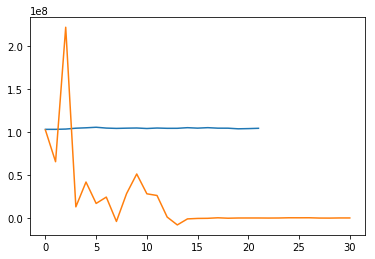

In [48]:
plt.plot(real_stock_price2)
plt.plot(forecast)
plt.show()